<p align="center">
<img src="https://www.uao.edu.co/wp-content/uploads/2024/12/uao-logo-2-04.webp" width=15%>


<h2>UNIVERSIDAD AUTÓNOMA DE OCCIDENTE</strong></h2>
<h3>03/06/2025 CALI - COLOMBIA</strong></h3>
<h3><strong>MAESTRIA EN INTELIGENCIA ARTIFICIAL Y CIENCIA DE DATOS</strong></h3>
<h3><strong>ETL (EXTRACT, TRANSFORM AND LOAD)</strong></h3>
<h3><strong>*   EJERCICIO EN CLASE 2: </strong>   TRANSFORMACIONES</h3>
<h3><strong>*   Profesor: </strong>    JAVIER ALEJANDRO VERGARA ZORRILLA</h3>
<h3><strong>*   Alumno: </strong>    Yoniliman Galvis Aguirre</h3>
<h3><strong>*   Código: </strong>    22500214 </h3>

# EJERCICIO ETL #2

## Contexto
Este conjunto de datos proviene de una empresa de comercio electrónico, que contiene diversa información sobre los productos disponibles en la tienda.

## Ejercicio
*   Realiza todas las transformaciones necesarias para obtener un conjunto de datos limpio con las características requeridas para '***Entrenar un modelo de aprendizaje automático que prediga si un producto es nuevo o usado***'.

*   Una característica es una columna con información importante o relevante para resolver el problema.

*   Toma en cuenta todas las consideraciones y supuestos que necesites. En la carpeta de Google Drive puedes encontrar el archivo data_clean.csv, el cual puedes usar como ejemplo de salida.

*   Realiza todo el Análisis Exploratorio de Datos (EDA) que consideres necesario, utiliza gráficos como apoyo y aplica todas las transformaciones requeridas.

---
# Verificar Kernel
Verificamos si el ambiente jupyter esta ejecutando el kernel en el entorno correcto, el resultado de las dos rutas debe coincidir, de lo contrario se debe de cambiar el kernel del jupyter notebook, una opcion es correr el enviroment desde poetry, en la terminal ejecute:

```bash
poetry run jupyter notebook
```
esto abrirá una version web de jupyter, en otro caso cambie el kernel y use los venv disponibles

Si el notebook esta ejecutando un kernel diferente a la carpeta del proyecto cuando instale librerías se presentarán fallas en la ejecucion del código del notebook

In [38]:
# Este chunk permite verificar si el entorno de VStudio y la carpeta de pyenv están sincronizadas, se cargan librerias canónicas de python
# Ejecuta tambien un comando sobre el bash (cmd en windows) para obtener el entorno de la carpeta de trabajo

import subprocess
import shutil

# Ejecutar el comando de poetry desde Python
result = subprocess.run(['poetry', 'env', 'info', '--path'], capture_output=True, text=True)

# Obtener la ruta del entorno virtual
env_path = result.stdout.strip()

# Obtener la ruta del ejecutable de Python activo
python_path = shutil.which("python")

print(f"El entorno virtual activo de poetry está en: {env_path}")
print(f"El entorno virtual activo del kernel en el notebook está en: {python_path}")

El entorno virtual activo de poetry está en: /home/ygalvis/Documents/Study/ETL_Ejercicio2/.venv
El entorno virtual activo del kernel en el notebook está en: /home/ygalvis/Documents/Study/ETL_Ejercicio2/.venv/bin/python


---
# DESARROLLO DEL EJERCICIO

## Preparación del sistema

In [39]:
# Cargar librerias para desarrollo del ejercicio
import pandas as pd                 # Para manejo de dataframes
import jsonlines                    # Para manejo de archivo json lineal
from tqdm import tqdm               # Para la barrita (percentfill) de proceso
import numpy as np                  # Para el procesamiento de numeros
import tensorflow as tf             # Para detectar GPU la que sea....
#import torch                       # Por si hay envidia.., no es para mi... a mi no me da envidia....
import matplotlib.pyplot as plt     # Para hacer graficos
import plotly.graph_objects as go   # Graficos
import re                           # para verificar un texto segun un patron determiando
import seaborn as sns               # para graficar la distribucion

#crear variable para separar la impresion de resultados de las operaciones del procesanmiento anteriores
separador = "\n<--" + "-" * 100 + "-->\n"

### Check GPU
Verificar la existencia de una GPU compatible

In [40]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(separador,"GPUs compatibles detectadas:",separador)
    for gpu in gpus:
        print(separador,gpu,separador)
    # Configuramos TensorFlow para que use la primera GPU encontrada
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    print(separador,"TensorFlow usará la primera GPU disponible.",separador)
else:
    print(separador,"Ups... No se detectó ninguna GPU, nos fuímos con la CPU!.",separador)


<-------------------------------------------------------------------------------------------------------->
 Ups... No se detectó ninguna GPU, nos fuímos con la CPU!. 
<-------------------------------------------------------------------------------------------------------->



## Cargar Dataset
Vamos a usar la librería jsonlines ya que conocemos que el dataset es tipo "***.jsonlines***"

### Funciones
Vamos a definir la funcion para tomar los datos del dataset y llevarlos a un dataframe.

In [41]:
# Leer el archivo Json lineal y hacer la prelimpieza
def leer_jsonl(ruta_archivo, ruta_exportar):
    """
    *   paso 1 Leemos un archivo JSONL y lo cargamos en un DataFrame.
    *   paso 2 Eliminamos columnas con valores nulos, listas vacías ([]), o diccionarios vacíos ({}).
    *   paso 3 Exportamos los encabezados y la primera fila a un archivo de texto para analisis de tablas grandes con muchas columnas.

    Args:
        ruta_archivo (str): En donde encontramos el archivo JSONL.
        ruta_exportar (str): En donde queremos colocar el archivo de texto donde se exportarán los encabezados y la primera fila para analisis posterior.

    Returns:
        pd.DataFrame: Devolvemos un DataFrame limpio con las columnas vacías eliminadas si las encuentra en el json.
    """
    # iniciao dataframe
    data = []
    
    # Intentar subir los datos
    try:
        with jsonlines.open(ruta_archivo) as reader:
            for obj in tqdm(reader, desc="*Proceso:* Leyendo líneas del archivo JSONL"):
                data.append(obj)
    
    # Manejo de errores que siempre puede haber!
    except FileNotFoundError:
        print(separador,"*Error 1:* No se encontró el archivo. Verifica la entrada de la ruta del archivo.",separador)
        return pd.DataFrame()
    except jsonlines.InvalidLineError as e:
        print(separador,f"*Error 2:* encontramos fallas al leer una línea del archivo. Revisa el JSON: {e}",separador)
        return pd.DataFrame()
    except Exception as e:
        print(separador,f"*Error 3:* tenemos un problema inesperado ó no reconocido: {e}",separador)
        return pd.DataFrame()

    # Convertir a DataFrame
    df = pd.DataFrame(data)

    if df.empty:
        print(separador,"*Advertencia:* El archivo JSONL está vacío o no pudimos cargarlo correctamente.",separador)
        return df

    # Exportar encabezados y primera fila alineados de forma vertical para mejor reconocimiento
    with open(ruta_exportar, "w", encoding="utf-8") as f:
        columnas = df.columns.tolist()
        valores = df.iloc[0].astype(str).tolist() if not df.empty else [""] * len(columnas)
        max_len = max(len(col) for col in columnas)

        f.write("Encabezado y primer fila:\n\n")
        for col, val in zip(columnas, valores):
            f.write(f"{col.rjust(max_len)} : {val}\n")

    print(separador,f"*Info:* El archivo ha sido exportado a: {ruta_exportar}",separador)
    return df

### Cargar Leer datos
Vamos a crear un archivo para poder observar la estructura de la tabla

In [42]:
ruta_archivo = 'Dataset/MLA_100k.jsonlines'
ruta_exportar = 'Dataset/header_firstrow.txt'
df = leer_jsonl(ruta_archivo, ruta_exportar)

# Presntar todas las columnas en formato vertical con las primera filas
pd.options.display.max_rows = None
print(separador,df.head(1).T,separador)

*Proceso:* Leyendo líneas del archivo JSONL: 100000it [00:08, 12279.23it/s]



<-------------------------------------------------------------------------------------------------------->
 *Info:* El archivo ha sido exportado a: Dataset/header_firstrow.txt 
<-------------------------------------------------------------------------------------------------------->


<-------------------------------------------------------------------------------------------------------->
                                                                                   0
seller_address                    {'comment': '', 'longitude': -58.3986709, 'id'...
warranty                                                                       None
sub_status                                                                       []
condition                                                                       new
seller_contact                                                                 None
deal_ids                                                                         []
base_price       

---
## Procesamiento de Datos
Vamos a procesar el dataframe, porque pueden haber columnas tipo diccionario (dict: {}) ó tipo lista (list: []), eso significa que esa columna posiblemente contiene un conjunto de columnas mas ó sea están anidadas

### Definir funciones

In [43]:
# DEfinimos una funcion para tomar una columna con estancias anidadas y las expandimos (descomponemos) 
# y obtenemos un dataframe diferente al de entrada vamos a tratar de no modificar el dataframe original.
# Vamos a usar tqdm de pandas para generar un percentfill por para que el usuario pueda percibir el progreso

# Activar el progress_apply de tqdm
tqdm.pandas()

def exploit_column(df, columna):
    """
    *   Vamos a expandir una única columna del DataFrame sin modificar el dataframe (df) original.
    *   Si la columna es de tipo lista (list: []) o diccionario (dict: {}) entonces se expande y retornamos
        un DataFrame con las columnas expandidas, donde para reconocer su origen inicial a nueva columna la nombraremos como <columna original>_<clave>.
    *   Si la columna no es una lista ni un diccionario entonces vamos a retornar un DataFrame que contiene
        únicamente la Serie original y conservando el encabezado original de la columna.
    
    Args:
        df (pd.DataFrame): Nombre del DataFrame de entrada.
        columna (str): Nombre de la columna a procesar en del Dataframe de entradas.
    
    Returns:
        pd.DataFrame: Si es lista o diccionario entonces se expande y se retorna un DataFrame con las columnas expandidas;
                      si no es lista ni diccionario no se expande, se retorna un DataFrame con la columna original y se conserva el encabezado.
    """
    if columna not in df.columns:
        print(separador,f"La columna ingresada: '{columna}', no existe en el DataFrame. Corrija el nombre antes de volver a intentar",separador)
        return pd.DataFrame()  # Retorna DataFrame vacío

    # Vamos a trabajar sobre una copia de la columna para no modificar el dataframe original
    serie = df[columna].copy()
    non_null = serie.dropna()
    
    if non_null.empty:
        print(separador,f"La columna ingresada: '{columna}', está vacía.",separador)
        return #serie.to_frame()  # Retorna DataFrame con la columna (vacía)

    primer_valor = non_null.iloc[0]
    
    # Caso 1: La columna es una lista
    if isinstance(primer_valor, list):
        # Reemplazar listas vacías por np.nan
        serie = serie.progress_apply(lambda x: np.nan if isinstance(x, list) and len(x) == 0 else x)
        
        # Verificar si, en las celdas no nulas, todos los elementos de la lista son diccionarios
        def is_list_of_dicts(x):
            if isinstance(x, list):
                return all(isinstance(item, dict) for item in x)
            return False
        
        # Si todas las celdas (no nulas) cumplen el patrón, fusionamos los diccionarios de cada celda
        if non_null.apply(is_list_of_dicts).all():
            def merge_dicts(dict_list):
                merged = {}
                for d in dict_list:
                    for k, v in d.items():
                        # Acumula los valores en una lista
                        merged.setdefault(k, []).append(v)
                # Convierte la lista en una cadena separada por comas
                return {k: ", ".join(map(str, v)) for k, v in merged.items()}
            # Aplicar fusión a cada celda (saltando NaN)
            serie = serie.progress_apply(lambda x: merge_dicts(x) if isinstance(x, list) else x)
            # Expandir el diccionario resultante
            df_expanded = pd.json_normalize(serie, sep="_")
            df_expanded = df_expanded.rename(columns=lambda c: f"{columna}_{c}")
            df_expanded.dropna(axis=1, how="all", inplace=True)
            return df_expanded
        else:
            # Caso alternativo: se explota la lista si no es exclusivamente de diccionarios
            if serie.progress_apply(lambda x: isinstance(x, list)).any():
                serie = serie.explode()
            if serie.progress_apply(lambda x: isinstance(x, dict)).any():
                df_expanded = pd.json_normalize(serie, sep="_")
                df_expanded = df_expanded.rename(columns=lambda c: f"{columna}_{c}")
                df_expanded.dropna(axis=1, how="all", inplace=True)
                return df_expanded
            else:
                return serie.to_frame()

    # Caso 2: La columna es un diccionario
    elif isinstance(primer_valor, dict):
        serie = serie.progress_apply(lambda x: np.nan if x is None or (isinstance(x, dict) and len(x) == 0) else x)
        if serie.notna().any() and serie.progress_apply(lambda x: isinstance(x, dict)).any():
            df_expanded = pd.json_normalize(serie, sep="_")
            df_expanded = df_expanded.rename(columns=lambda c: f"{columna}_{c}")
            df_expanded.dropna(axis=1, how="all", inplace=True)
            return df_expanded
        else:
            return serie.to_frame()

    # Caso 3: La columna no es ni lista ni diccionario
    else:
        # Retornar la columna original envuelta en un DataFrame
        return serie.to_frame()

In [44]:
# Esta funcion recibe un dataframe y una lista de columnas que queremos expandir, si no ingresamos la lista de columnas 
# se procesarán todas las columnas existentes en el dataframe y si encuentra columnas con anidadas las expandirá,
# la salida es un dataframe diferente al de entrada, incluirá las columnas originales que no estaban anidadas
# y todas las que antes estaban anidadas pero expandidas y el encabezado incluirá el nombre de la columna original
# esto con el fin de poder rastrear la columna hasta el origen en el dataframe original

def exploit_df(df, lista_columnas=None):
    """
    *   Utilizando la función llamada 'exploit_column' procesaremos, columna a columna, el DataFrame de entrada
        luego concatenamos horizontalmente los resultados omitiendo las columnas resultantes que estén completamente vacías.
    
    *   Si no se especifica 'lista_columnas', se procesan todas las columnas.
    
    *   Se concerva el Dataframe de entrada y en el DataFrame final de salida se reemplazan todos los valores None por np.nan.
    
    Args:
        df (pd.DataFrame): DataFrame de entrada, al que queremos expandir si es necesario.
        lista_columnas (list, optional): Lista de nombres de columna a expandir si deseamos obtener solo las columnas a expandir.
        
    Returns:
        pd.DataFrame: Un nuevo DataFrame con las columnas procesadas, 
                      omitiendo las completamente vacías y con None reemplazados por np.nan.
    """
    if lista_columnas is None:
        lista_columnas = df.columns.tolist()

    resultados = []
    for col in lista_columnas:
        # Paso 1: llamando a la función 'exploit_column' (previamente definida)
        res = exploit_column(df, col)
        if res is not None:
            # Paso 2: Eliminando columnas que estén completamente vacías (solo NaN)
            res_filtrado = res.dropna(axis=1, how="all")
            if not res_filtrado.empty:
                resultados.append(res_filtrado.reset_index(drop=True))
    
    if resultados:
        df_resultante = pd.concat(resultados, axis=1)
        # Reemplazamos los None por np.nan en el DataFrame final
        df_resultante = df_resultante.replace({None: np.nan})
        return df_resultante
    else:
        return pd.DataFrame()

### Expansion del Dataframe
Usando las funciones: 'exploit_column' y 'exploit_df' vamos a pasarle el Dataframe donde está la informacion que cargamos del "***.jsonlines***".
Esto nos va ha generar un nuevo Dataframe sin columnas anidadas, sin columnas vacias y con valores nulos como np.nan

Vamos a desplegar el dataframe expandido mostrando el encabezado y la primera fila en formato vertical para facilitar la visualizacion y comprension

In [45]:
# Procesar todas las columnas del JSON Dataframe
df_exploit= exploit_df(df)

100%|██████████| 100000/100000 [00:00<00:00, 151795.17it/s]



<-------------------------------------------------------------------------------------------------------->
 La columna ingresada: 'differential_pricing', está vacía. 
<-------------------------------------------------------------------------------------------------------->


<-------------------------------------------------------------------------------------------------------->
 La columna ingresada: 'subtitle', está vacía. 
<-------------------------------------------------------------------------------------------------------->



100%|██████████| 100000/100000 [00:00<00:00, 1534548.25it/s]


Como se observa se eliminaron 2 columnas que estaban vacias: [***differential_pricing***, ***subtitle***]

## Análisis Exploratorio
*   "***df_exploit***": es el Dataframe expandido listo para seguir el análisis.
*   Vamos a definir las funciones que sean necesarias
*   Vamos a generar un resumen donde podamos ver el tamaño del dataset cantidad de columnas y el numero de filas.
*   Analizar si se tienen faltantes
*   Estadistica descriptiva básica.
*   Ver la distribucion de las variables
*   Analizar si hay correlaciones

In [46]:
# Funcion para mostrar los tipos de columnas de un dataframe pero organizado de forma mas intuitiva
def types_column(df):
    """
    Vamos a presentar en un DataFrame cada tipo de dato de la lista de columnas del DataFrame original organizado por tipo.
    
    Args:
        df (pd.DataFrame): DataFrame de entrada.
        
    Returns:
        pd.DataFrame: DataFrame con dos columnas: 'tipo' y 'columnas'.
                    'tipo' indica el tipo de dato y 'columnas' es una lista de nombres.
    """
    num_filas, num_columnas = df.shape
    print(separador,f"El DataFrame tiene {num_filas} filas y {num_columnas} columnas.",separador)
    print(f"informacion. {df.info()}",separador)
    
    df_tipos = (
        df.dtypes
          .reset_index()
          .rename(columns={'index': 'columna', 0: 'tipo'})
          .groupby('tipo')['columna']
          .apply(list)
          .reset_index()
          .rename(columns={'columna': 'columnas'})
    )
    print(separador,df_tipos,separador)
    return df_tipos

In [47]:
# Vamos a tomar un DataFrame y presentar un gráfico de barras con el porcentaje de valores "missing" por columna:
def plot_missing(df, figsize=(12, 6), color='skyblue', rotation=45, title="Porcentaje de valores missing por columna"):
    """
    Generamos un gráfico de barras que muestra el porcentaje de valores missing (NaN) en cada columna del DataFrame.

    Args:
        df (pd.DataFrame): DataFrame que queremos analizar.
        figsize (tuple, optional): Definimos el Tamaño de la figura (ancho, alto). Por defecto (12, 6).
        color (str, optional): Definimos el color de las barras. Por defecto 'skyblue'.
        rotation (int, optional): Rotar las etiquetas del eje x. Por defecto 45.
        title (str, optional): EL título del gráfico. Por defecto "% de valores missing por columna".

    Returns:
        None: Mostramos el gráfico.
    """
    # Calculamos el porcentaje de los valores missing por cada columna
    missing_percent = df.isnull().mean() * 100

    # Ordenamos las columnas dependiendo del porcentaje de missing (de mayor a menor)
    missing_percent = missing_percent.sort_values(ascending=False)

    # Crear el gráfico
    plt.figure(figsize=figsize)
    missing_percent.plot(kind='bar', color=color)
    plt.ylabel("% de valores missing")
    plt.xlabel("Columnas")
    plt.title(title)
    plt.xticks(rotation=rotation, ha='right')
    plt.tight_layout()
    plt.show()

### Resumen General y Dimensiones
Observar el dataframe como un conjunto

In [48]:
# Ver informacion
print("DataFrame Summary:")

# guardar informacion de los encabezados por tipo de valor
df_types = types_column(df_exploit)

print("DataFrame Header:")
print(separador,df_exploit.head(1).T,separador)
print("DataFrame Tail:")
print(separador,df_exploit.tail(1).T,separador)


DataFrame Summary:

<-------------------------------------------------------------------------------------------------------->
 El DataFrame tiene 101626 filas y 106 columnas. 
<-------------------------------------------------------------------------------------------------------->

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101626 entries, 0 to 101625
Columns: 106 entries, seller_address_comment to available_quantity
dtypes: float64(9), object(97)
memory usage: 82.2+ MB
informacion. None 
<-------------------------------------------------------------------------------------------------------->


<-------------------------------------------------------------------------------------------------------->
       tipo                                           columnas
0  float64  [base_price, seller_id, price, official_store_...
1   object  [seller_address_comment, seller_address_longit... 
<--------------------------------------------------------------------------------------------

### Leer datos de los encabezados del dataframe expandido
Vamos a crear un archivo para poder observar la estructura de la tabla

In [49]:
ruta_exportar = 'Dataset/header_firstrow_exploit.txt'
# Exportar la primera fila a un archivo de texto
df_exploit.head(1).to_csv(ruta_exportar, index=False, sep='\t')

# Presentar todas las columnas en formato vertical con las primera filas
pd.options.display.max_rows = None
print(separador,df_exploit.head(1).T,separador)

# Guardar el Dataset original y el expandido para revision externa
df.to_csv("Dataset/output1.csv", index=False)
df_exploit.to_csv("Dataset/output2.csv", index=False)



<-------------------------------------------------------------------------------------------------------->
                                                                                                   0
seller_address_comment                                                                             
seller_address_longitude                                                                 -58.398671
seller_address_id                                                                          78162842
seller_address_address_line                                                                        
seller_address_latitude                                                                   -34.62807
seller_address_zip_code                                                                            
seller_address_country_name                                                               Argentina
seller_address_country_id                                                                  

# Selección de Columnas pertinentes

*   Vamos a seleccionar del archivo expandido las columnas relacionadas a:
'***Entrenar un modelo de aprendizaje automático que prediga si un producto es nuevo o usado***'

*   Vamos a analizar las columnas en el idioma ingles, para determinarr si contiene información sensible, vamos a usar a Scrubadub y/o presidio  las cuales sona librerías especializadas para uso desde python que están diseñada para idenificar y limpiar información sensible (PII - PPersonal Identifiable Information).

*   Una vez identifiquemos la probabilidad del que sean datos sensibles es necesario analizar puntualmente columna a columna para verificar si eliminar cualquier columna no afecte la funcionalidad del dataset (esto ya que estas librerías pueden llegar a cometer errores al analizar la información).

*   Una vez analicemos el PII Score, usando presidio, vamos a exportar el dataset resultante y lo vamos a editar, manualmente intentaré hacer una breve y probable explicación de la funcion de cada columna y de esta forma mejorar el entendimiento del dataset.

*   Una vez se tenga el conocimiento básico del dataser se estimará la participación de cada columna para la intensión de este estudio, se intentará estimar un posible porcentaje de participacion con el fin de ayudar a simplificar el dataset mas adelante.

### Manejo de PII

1.  **Scrubadub:** Es una librería de Python que ha sido diseñada para identificar y limpiar información sensible (PII) de textos y aunque está orientada a trabajar con datos textuales se puede integrara en pipelines de preprocesamiento para detectar y reemplazar datos sensibles.

2.  **Microsoft Presidio:** Es una herramienta de código abierto que fúe desarrollada por Microsoft para detectar, analizar y anonimizar información sensible (PII) en textos, la librería está compuesta por dos módulos principales:

    *   presidio-analyzer: Detecta entidades sensibles en textos usando una combinación de reglas y modelos de NLP.
    *   presidio-anonymizer: Permite anonimizar o reemplazar esas entidades sensibles en el texto.

    Para esta librería el score representa la confianza en que un fragmento de texto es sensible, donde 1 (100%) es la mayor confianza (el modelo considera que el texto contiene información sensible), al mayor score obtenido en las detecciones de un grupo de análisis se considera el mayor score natural.



* Scrubadub, [https://scrubadub.readthedocs.io/en/stable/index.html]
* Microsoft Presidio, [https://microsoft.github.io/presidio/], [https://microsoft.github.io/presidio/api/structured_python/]

In [50]:
# librerias de manejo PII
import scrubadub
from presidio_analyzer import AnalyzerEngine

In [51]:
# Definir funciones para usar presidio_analyzer

def get_column_natural_score(column_values, analyzer, language="en", sample_size=20):
    """
    Inicialmente vamos a ralizar un analisis a una muestra aleatoria (sample_size) de los valores de una columna usando Presidio y 
    vamos a devolver el mayor score natural obtenido entre las detecciones, si no se detecta nada en la muestra, retornamos 0.
    """
    all_scores = []
    
    # Tomamos una muestra aleatoria de sample_size registros no nulos.
    non_null_values = column_values.dropna().astype(str)
    
    # Si hay una cantidad menor de registros que el sample_size dado, tomamos todos los registros disponibles,
    # usamos random_state como semilla para que podamos reproducir el resultado
    sample = non_null_values.sample(n=sample_size, random_state=42) if len(non_null_values) >= sample_size else non_null_values
    
    # Analizamos
    for text in sample:
        results = analyzer.analyze(text=text, language=language)
        for res in results:
            all_scores.append(res.score)
    return max(all_scores) if all_scores else 0

def score_dataframe_presidio_natural(df, sample_size=20, language="en"):
    """
    Tomamos cada columna del DataFrame, analizamos una muestra de sus datos y devolvemos un nuevo DataFrame
    con el nombre de la columna y el score natural que devuelve Presidio y obtenido a partir del análisis.
    """
    analyzer = AnalyzerEngine()
    scores_list = []
    
    # Anlisis
    for col in df.columns:
        # tomamos la muestra de la columna respectiva 
        sample = df[col].dropna().astype(str).head(sample_size)
        # analisamos la columna usando la función "get_column_natural_score" 
        col_score = get_column_natural_score(sample, analyzer, language, sample_size)
        # guardamos el score resultado
        scores_list.append({"column": col, "presidio_score": col_score})
    return pd.DataFrame(scores_list)

In [52]:
# Vamos a obtener el DataFrame con el score PII desde Presidio para cada columna del dataframe expandido
df_scores = score_dataframe_presidio_natural(df_exploit, sample_size=30, language="en")

# Guardar el Dataset analizado por  y el expandido para revision externa
df_scores.to_csv("Dataset/df_scores.csv", index=False)


# Cargar Archivo de columnas explicado y estimado
Hemos tomado el archivo exportado con las columnas expandidas y los scores de PII, externamente hemos adicionado una estimación de la descripcion y un porcentaje de pertinencia con el caso propuesto.
Adicionalmente vamos a graficar para observar las columnas con scores mas altos de un umbral de 50% y con pertinencias mas altas del 50% vamos a ver si las columnas pertienetes tienen scores altos
Adicionalmente observando el score y analizando el tipo de columna definimos si borrar o no la columna.

/tmp/ipykernel_776899/1211035639.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(df_filtrado['column'], rotation=90, fontsize=8)
/tmp/ipykernel_776899/1211035639.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(df_filtrado['column'], rotation=90, fontsize=8)


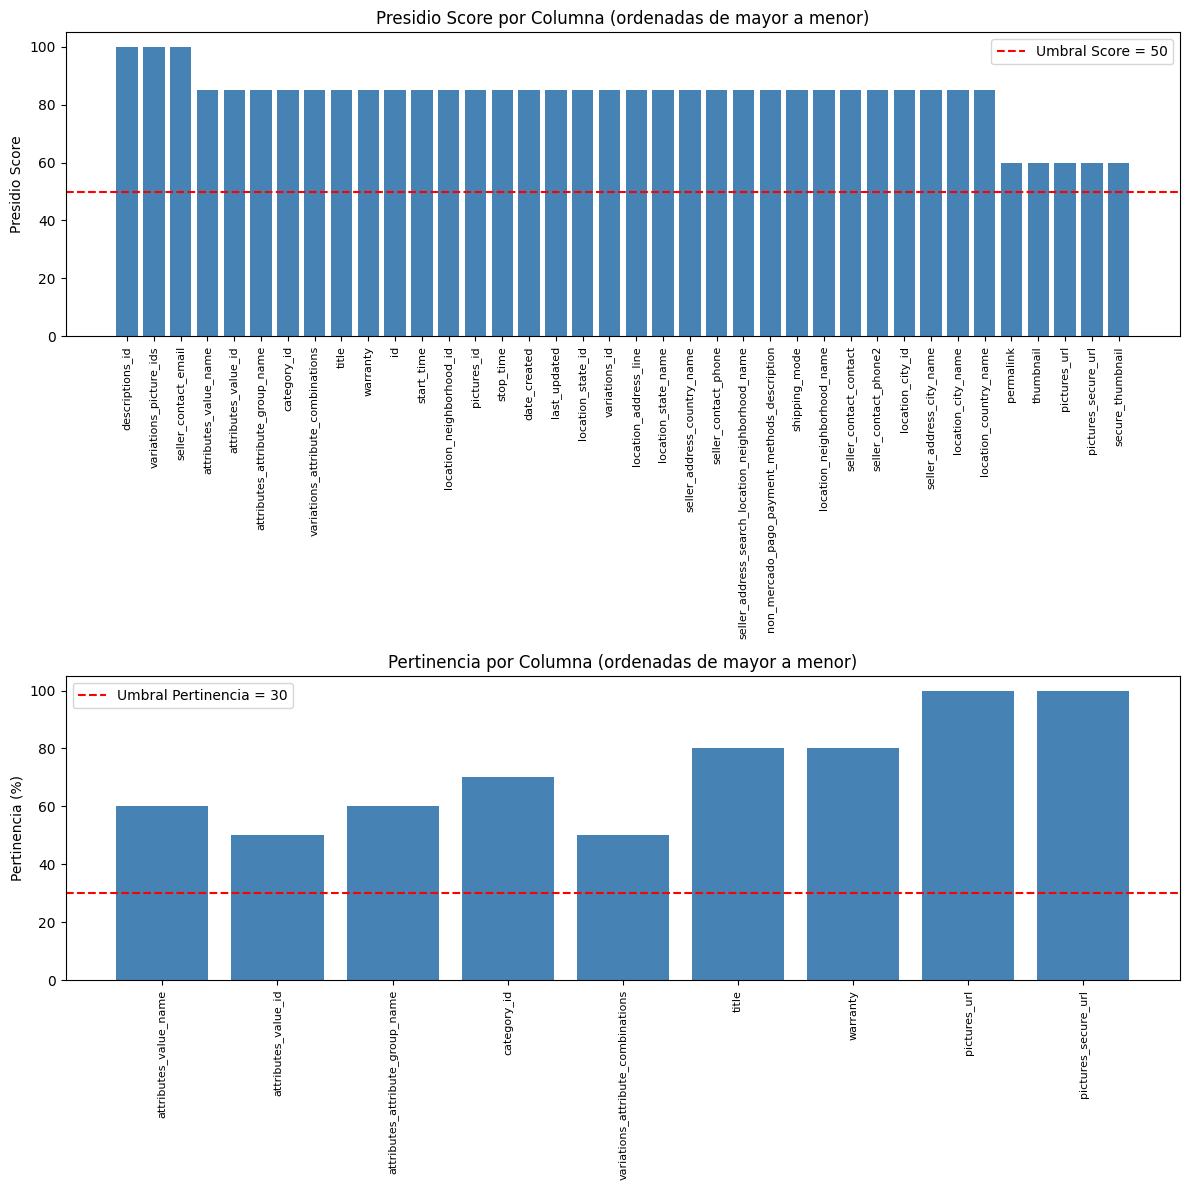

In [53]:
# Cargar archivo
df_exploit_desc_scored = pd.read_csv('Dataset/df_exploit_PIIscores_explain.csv')

# Ordenar el DataFrame por presidio_score de mayor a menor
df_sorted_sc = df_exploit_desc_scored.sort_values(by='presidio_score', ascending=False)

# Ordenar el DataFrame por ppertinencia score de mayor a menor
df_sorted_ut= df_exploit_desc_scored.sort_values(by='Utilización', ascending=False)

# Definir umbrales para score y para la pertinencia de la columna
umbral_score    = 50
umbral_pert     = 30  # Un umbral de frecuencia (por ejemplo, solo queremos resaltar categorías con 3 o más columnas)

# Crear la figura con dos subplots verticales
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Garficar

df_filtrado = df_sorted_sc[df_sorted_sc['presidio_score'] >= umbral_score]

# Gráfico 1: Presidio Score
axes[0].bar(df_filtrado['column'], df_filtrado['presidio_score'], color='steelblue')
# Agregamos una línea horizontal en el umbral
axes[0].axhline(umbral_score, color='red', linestyle='--', label=f'Umbral Score = {umbral_score}')
axes[0].set_title('Presidio Score por Columna (ordenadas de mayor a menor)')
axes[0].set_ylabel('Presidio Score')
axes[0].set_xticklabels(df_filtrado['column'], rotation=90, fontsize=8)
axes[0].legend()

# Convertir "Utilización (%)" a un rango de 0 a 1 y filtrar según el umbral de pertinencia
# porque la columna "Utilización (%)" está en el rango 0 a 100
df_filtrado = df_filtrado[df_filtrado['Utilización'] >= umbral_pert]

# Gráfico 2: Pertinencia
axes[1].bar(df_filtrado['column'], df_filtrado['Utilización'], color='steelblue')
# Agregamos una línea horizontal en el umbral_pert
axes[1].axhline(umbral_pert, color='red', linestyle='--', label=f'Umbral Pertinencia = {umbral_pert}')
axes[1].set_title('Pertinencia por Columna (ordenadas de mayor a menor)')
axes[1].set_ylabel('Pertinencia (%)')
axes[1].set_xticklabels(df_filtrado['column'], rotation=90, fontsize=8)
axes[1].legend()

plt.tight_layout()
plt.show()

In [54]:
df_sorted = df_exploit_desc_scored.sort_values(
    by=['Utilización', 'presidio_score'],
    ascending=[False, True]
)

df_sorted[df_exploit_desc_scored["Pertinencia"].isin(["Alta", "Media"])]

,column,Descripción,Pertinencia,Utilización,presidio_score,Delete_mark
0,video_id,"Identificador del video asociado al producto, ...",Alta,100,0,False
1,condition,Condición del producto (nuevo/usado). Variable...,Alta,100,0,False
2,pictures_secure_url,URL segura para acceder a las imágenes.,Alta,100,60,False
3,pictures_url,URL de las imágenes del producto.,Alta,100,60,False
4,price,Precio final de venta del producto.,Alta,90,0,False
5,pictures_size,Tamaño de las imágenes del producto.,Alta,90,0,False
6,variations_seller_custom_field,Campo personalizado definido por el vendedor p...,Alta,90,0,False
7,base_price,Precio base del producto.,Alta,85,0,False
8,original_price,"Precio original del producto, antes de descuen...",Alta,85,0,False
9,variations_price,Precio específico de cada variación.,Media,80,0,False


# Dataframe pertinente
Despues de analizar las columans que describimos como pertienentes y que despues del analisis no corresponden a infromacion personal, creamos el dataframe de salida

In [55]:
# Vamos a obtener la lista de columnas a borrar donde Delete_mark es True
cols_to_delete = df_exploit_desc_scored.loc[df_exploit_desc_scored['Delete_mark'] == True, 'column'].tolist()

# Eliminamos esas columnas del DataFrame df_exploit_desc
df_exploit_clean = df_exploit.drop(columns=cols_to_delete)

df_exploit_clean.head(10)


,seller_address_search_location_neighborhood_name,warranty,sub_status,condition,deal_ids,base_price,variations_attribute_combinations,variations_seller_custom_field,variations_sold_quantity,variations_available_quantity,...,category_id,pictures_size,pictures_secure_url,pictures_url,original_price,title,automatic_relist,video_id,sold_quantity,available_quantity
0,San Cristóbal,NaN,NaN,new,NaN,80.0,NaN,NaN,NaN,NaN,...,MLA126406,"500x375, 500x375",https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,http://mla-s1-p.mlstatic.com/5386-MLA435206787...,NaN,Auriculares Samsung Originales Manos Libres Ca...,False,NaN,0.0,1.0
1,Villa Devoto,NUESTRA REPUTACION,NaN,used,NaN,2650.0,NaN,NaN,NaN,NaN,...,MLA10267,"499x334, 500x375, 500x375, 500x375, 500x375, 5...",https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,http://mla-s1-p.mlstatic.com/23223-MLA20245018...,NaN,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,False,NaN,0.0,1.0
2,Boedo,NaN,NaN,used,NaN,60.0,NaN,NaN,NaN,NaN,...,MLA1227,375x500,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,http://mla-s1-p.mlstatic.com/22076-MLA20223367...,NaN,"Antigua Revista Billiken, N° 1826, Año 1954",False,NaN,0.0,1.0
3,Floresta,NaN,NaN,new,NaN,580.0,NaN,NaN,NaN,NaN,...,MLA86345,"441x423, 500x372",https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,http://mla-s2-p.mlstatic.com/183901-MLA2043288...,NaN,Alarma Guardtex Gx412 Seguridad Para El Automo...,False,NaN,0.0,1.0
4,,MI REPUTACION.,NaN,used,NaN,30.0,NaN,NaN,NaN,NaN,...,MLA41287,"375x500, 375x500",https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,http://mla-s2-p.mlstatic.com/13595-MLA13041807...,NaN,Serenata - Jennifer Blake,False,NaN,0.0,1.0
5,Villa Adelina,Sí,NaN,new,NaN,310.0,NaN,NaN,NaN,NaN,...,MLA1429,250x250,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,http://mla-s2-p.mlstatic.com/6207-MLA87256964_...,NaN,Clavo De Olor(*1/2) Grano Origen Turquia,False,NaN,0.0,1.0
6,Barracas,NaN,NaN,used,NaN,180.0,"[{'value_id': '92012', 'name': 'Color Primario...",None,0,1,...,MLA352650,"500x375, 500x375, 500x375, 500x375, 500x375",https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,http://mla-s1-p.mlstatic.com/472901-MLA2044293...,NaN,Short Nike Fit Boca Juniors Talle S 7-8 Años,False,NaN,0.0,1.0
7,,NaN,NaN,used,NaN,150.0,NaN,NaN,NaN,NaN,...,MLA1227,"500x375, 500x375, 500x375, 500x375, 500x375",https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,http://mla-s2-p.mlstatic.com/9874-MLA200219365...,NaN,Plaza De Toros Iglesias Vistas Aereas De Españ...,False,NaN,0.0,1.0
8,,1 Ano,NaN,new,NaN,2352.0,NaN,NaN,NaN,NaN,...,MLA352293,"500x500, 500x299, 500x500",https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,http://mla-s1-p.mlstatic.com/797901-MLA2043624...,NaN,Kit X2 Amortiguador Trasero Monroe Chrysler Ca...,True,QQNfOicE_o8,0.0,10.0
9,Monte Grande,NaN,NaN,new,NaN,120.0,"[{'value_id': '92021', 'name': 'Color Primario...",None,1,1,...,MLA121665,"375x500, 375x500",https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,http://mla-s1-p.mlstatic.com/22802-MLA20237759...,NaN,Bonitas Mallas Color Fuccia Talle 1 Y 2,False,NaN,1.0,1.0


### Analisis de faltantes

### Gráfica de Cumplimiento de Datos
*   Vamos a presentar una gráfica donde se muestre la cantidad de datos vacios (nulos, none, nan o faltantes) por columna de cada Dataframe (original y expandido)
*   Tener en cuenta que a **mayor porcentaje es mayor cantidad de datos vacios**.

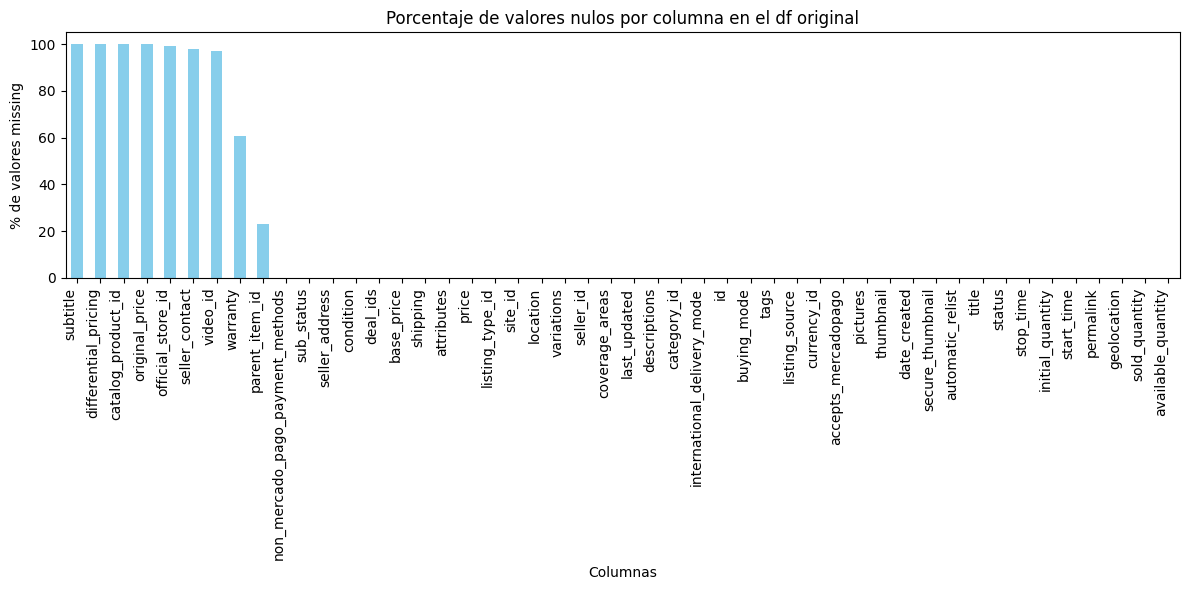

In [56]:
# Faltantes del Dataframe Original
plot_missing(df, rotation = 90, title= "Porcentaje de valores nulos por columna en el df original")

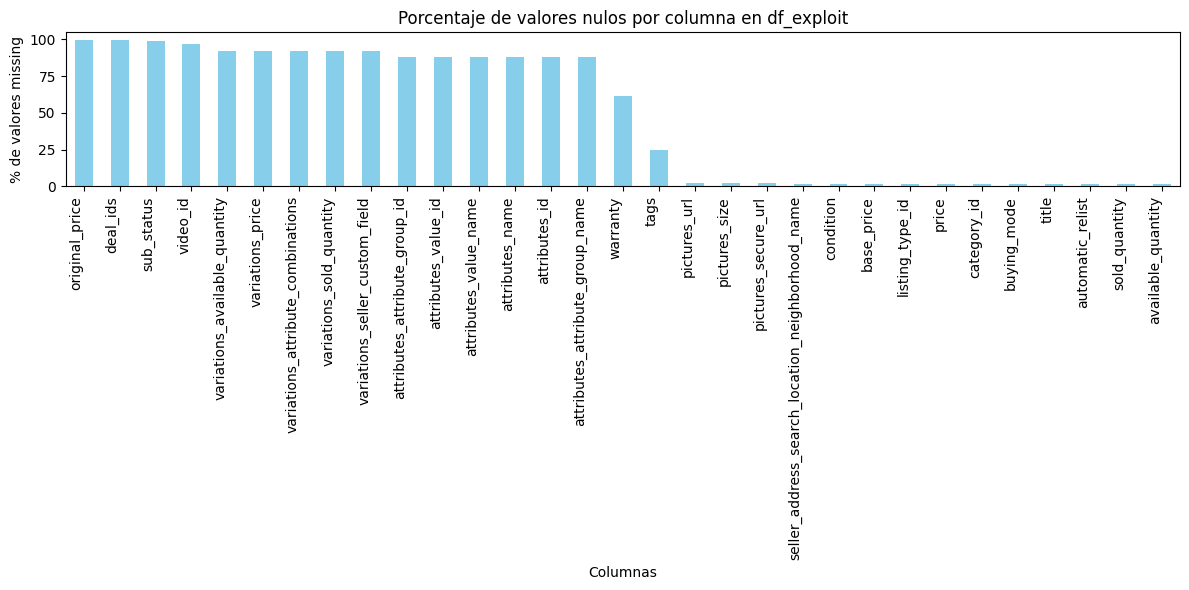

In [57]:
# Faltantes del Dataframe Expandido
plot_missing(df_exploit_clean, rotation = 90, title= "Porcentaje de valores nulos por columna en df_exploit")

### Ver columnas con nulos
Vamos a observar las columnas con nulos desde el Dataframe original y el Dataframe expandido, esto nos permite verificar el proceso de expansion de las columnas anidadas

In [58]:
# Resumen de Columnas Vacias dataframe inicial
missing = df.isna().sum().sort_values(ascending=False)
vacias = missing[missing > 50]
df[vacias.index].head(10), df[vacias.index].tail(10)

(  subtitle differential_pricing  catalog_product_id  original_price  \
 0     None                 None                 NaN             NaN   
 1     None                 None                 NaN             NaN   
 2     None                 None                 NaN             NaN   
 3     None                 None                 NaN             NaN   
 4     None                 None                 NaN             NaN   
 5     None                 None                 NaN             NaN   
 6     None                 None                 NaN             NaN   
 7     None                 None                 NaN             NaN   
 8     None                 None                 NaN             NaN   
 9     None                 None                 NaN             NaN   
 
    official_store_id seller_contact     video_id            warranty  \
 0                NaN           None         None                None   
 1                NaN           None         None  NUESTRA R

# Ver las columnas con datos perdidos en el Dataframe expandido

In [59]:
# Resumen de Columnas Vacias dataframe expandido y limpio
missing = df_exploit_clean.isna().sum().sort_values(ascending=False)
vacias = missing[missing > 50]
df_exploit_clean[vacias.index].head(10), df_exploit_clean[vacias.index].tail(10)

(   original_price deal_ids sub_status     video_id  \
 0             NaN      NaN        NaN          NaN   
 1             NaN      NaN        NaN          NaN   
 2             NaN      NaN        NaN          NaN   
 3             NaN      NaN        NaN          NaN   
 4             NaN      NaN        NaN          NaN   
 5             NaN      NaN        NaN          NaN   
 6             NaN      NaN        NaN          NaN   
 7             NaN      NaN        NaN          NaN   
 8             NaN      NaN        NaN  QQNfOicE_o8   
 9             NaN      NaN        NaN          NaN   
 
   variations_available_quantity variations_price  \
 0                           NaN              NaN   
 1                           NaN              NaN   
 2                           NaN              NaN   
 3                           NaN              NaN   
 4                           NaN              NaN   
 5                           NaN              NaN   
 6                    

# Eliminar columnas vacias
Vamos a eliminar columnas con mas de 50% de perdidas

In [60]:
# Definimos un número mínimo de valores no nulos requeridos para conservar la columna en el dataframe
umbral = len(df_exploit_clean) * 0.5

# Eliminamos las columnas que no alcanzan ese número de valores no nulos
df_exploit_clean = df_exploit_clean.dropna(axis=1, thresh=umbral)

print("DataFrame limpio:")
df_exploit_clean.head()

DataFrame limpio:


,seller_address_search_location_neighborhood_name,condition,base_price,listing_type_id,price,buying_mode,tags,category_id,pictures_size,pictures_secure_url,pictures_url,title,automatic_relist,sold_quantity,available_quantity
0,San Cristóbal,new,80.0,bronze,80.0,buy_it_now,dragged_bids_and_visits,MLA126406,"500x375, 500x375",https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,http://mla-s1-p.mlstatic.com/5386-MLA435206787...,Auriculares Samsung Originales Manos Libres Ca...,False,0.0,1.0
1,Villa Devoto,used,2650.0,silver,2650.0,buy_it_now,NaN,MLA10267,"499x334, 500x375, 500x375, 500x375, 500x375, 5...",https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,http://mla-s1-p.mlstatic.com/23223-MLA20245018...,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,False,0.0,1.0
2,Boedo,used,60.0,bronze,60.0,buy_it_now,dragged_bids_and_visits,MLA1227,375x500,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,http://mla-s1-p.mlstatic.com/22076-MLA20223367...,"Antigua Revista Billiken, N° 1826, Año 1954",False,0.0,1.0
3,Floresta,new,580.0,silver,580.0,buy_it_now,NaN,MLA86345,"441x423, 500x372",https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,http://mla-s2-p.mlstatic.com/183901-MLA2043288...,Alarma Guardtex Gx412 Seguridad Para El Automo...,False,0.0,1.0
4,,used,30.0,bronze,30.0,buy_it_now,dragged_bids_and_visits,MLA41287,"375x500, 375x500",https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,http://mla-s2-p.mlstatic.com/13595-MLA13041807...,Serenata - Jennifer Blake,False,0.0,1.0


# Completar columnas numericas con numero perdidos
Vamos a bucar si en el dataframe en proceso hay columnas numéricas con datos perdidos para preprocesarlos

In [61]:
# Seleccionamos las columnas no categóricas (numéricas, por ejemplo)
non_cat_cols = df_exploit_clean.select_dtypes(exclude=['object', 'category']).columns

# Filtramos las columnas numéricas que tengan al menos un valor nulo
cols_with_na = [col for col in non_cat_cols if df_exploit_clean[col].isnull().any()]

print("Columnas no categóricas con valores nulos:")
print(cols_with_na)

Columnas no categóricas con valores nulos:
['base_price', 'price', 'sold_quantity', 'available_quantity']


In [64]:
# Completar los valores nulos de los 'valores' con el promedio del grupo definido por 'buying_mode' y 'category_id'
df_exploit_clean['base_price'] = df_exploit_clean['base_price'].fillna(df_exploit_clean.groupby(['category_id'])['base_price'].transform('mean'))
df_exploit_clean['price'] = df_exploit_clean['base_price'].fillna(df_exploit_clean.groupby(['category_id'])['price'].transform('mean'))
df_exploit_clean['sold_quantity'] = df_exploit_clean['sold_quantity'].fillna(df_exploit_clean.groupby(['category_id'])['sold_quantity'].transform('mean'))
df_exploit_clean['available_quantity'] = df_exploit_clean['available_quantity'].fillna(df_exploit_clean.groupby(['category_id'])['available_quantity'].transform('mean'))

## Eliminar filas que no se pudieron completar

In [68]:
df_exploit_clean = df_exploit_clean.dropna(subset=['condition'])

### VErificacion

In [70]:
# Seleccionamos las columnas no categóricas (numéricas, por ejemplo)
non_cat_cols = df_exploit_clean.select_dtypes(exclude=['object', 'category']).columns

# Filtramos las columnas numéricas que tengan al menos un valor nulo
cols_with_na = [col for col in non_cat_cols if df_exploit_clean[col].isnull().any()]

print("Columnas no categóricas con valores nulos:")
print(cols_with_na)

Columnas no categóricas con valores nulos:
[]


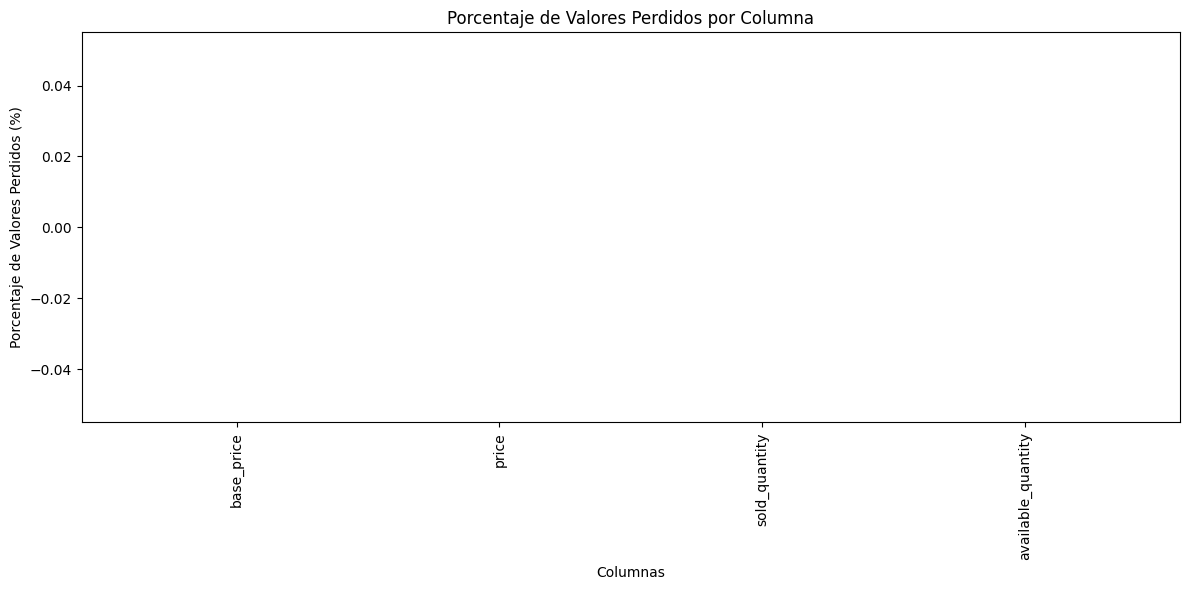

In [71]:
# Seleccionamos las columnas que no son de tipo objeto ni categoría (es decir, columnas numéricas u otros tipos)
df_non_cat = df_exploit_clean.select_dtypes(exclude=['object', 'category'])

# Calculamos el porcentaje de los valores nulos por cada columna
missing_percentage = df_non_cat.isnull().mean() * 100

# Creamos el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(missing_percentage.index, missing_percentage.values, color='orange')
plt.xlabel('Columnas')
plt.ylabel('Porcentaje de Valores Perdidos (%)')
plt.title('Porcentaje de Valores Perdidos por Columna')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Eliminar columnas no categoricas con mas del 50% de valores perdidos

In [72]:
# Seleccionar las columnas no categóricas (excluyendo 'object' y 'category')
non_cat = df_exploit_clean.select_dtypes(exclude=['object', 'category'])

# Identificar las columnas no categóricas que tienen más del 50% de valores nulos
cols_to_drop = non_cat.columns[non_cat.isnull().mean() > 0.5]

# Eliminar esas columnas del DataFrame original
df_exploit_clean = df_exploit_clean.drop(columns=cols_to_drop)

In [27]:
df_exploit_clean.head()

,seller_address_search_location_neighborhood_name,condition,base_price,listing_type_id,price,buying_mode,tags,category_id,pictures_size,pictures_secure_url,pictures_url,title,automatic_relist,sold_quantity,available_quantity
0,San Cristóbal,new,80.0,bronze,80.0,buy_it_now,dragged_bids_and_visits,MLA126406,"500x375, 500x375",https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,http://mla-s1-p.mlstatic.com/5386-MLA435206787...,Auriculares Samsung Originales Manos Libres Ca...,False,0.0,1.0
1,Villa Devoto,used,2650.0,silver,2650.0,buy_it_now,NaN,MLA10267,"499x334, 500x375, 500x375, 500x375, 500x375, 5...",https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,http://mla-s1-p.mlstatic.com/23223-MLA20245018...,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,False,0.0,1.0
2,Boedo,used,60.0,bronze,60.0,buy_it_now,dragged_bids_and_visits,MLA1227,375x500,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,http://mla-s1-p.mlstatic.com/22076-MLA20223367...,"Antigua Revista Billiken, N° 1826, Año 1954",False,0.0,1.0
3,Floresta,new,580.0,silver,580.0,buy_it_now,NaN,MLA86345,"441x423, 500x372",https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,http://mla-s2-p.mlstatic.com/183901-MLA2043288...,Alarma Guardtex Gx412 Seguridad Para El Automo...,False,0.0,1.0
4,,used,30.0,bronze,30.0,buy_it_now,dragged_bids_and_visits,MLA41287,"375x500, 375x500",https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,http://mla-s2-p.mlstatic.com/13595-MLA13041807...,Serenata - Jennifer Blake,False,0.0,1.0


# Organizar columnas

In [73]:
# Extraer columnas por tipo
object_cols = df_exploit_clean.select_dtypes(include=['object']).columns.tolist()
categorical_cols = df_exploit_clean.select_dtypes(include=['category']).columns.tolist()
numeric_cols = df_exploit_clean.select_dtypes(include=['number']).columns.tolist()

# Reorganizar el DataFrame concatenando las listas de columnas en el orden deseado:
nuevo_orden = object_cols + categorical_cols + numeric_cols
df_exploit_clean_reorder = df_exploit_clean[nuevo_orden]

# Mostrar resultados
print("Columnas de tipo 'object':", object_cols)
print("Columnas de tipo 'category':", categorical_cols)
print("Columnas numéricas:", numeric_cols)
print("\nDataFrame reorganizado:")
df_exploit_clean_reorder.head()

Columnas de tipo 'object': ['seller_address_search_location_neighborhood_name', 'condition', 'listing_type_id', 'buying_mode', 'tags', 'category_id', 'pictures_size', 'pictures_secure_url', 'pictures_url', 'title', 'automatic_relist']
Columnas de tipo 'category': []
Columnas numéricas: ['base_price', 'price', 'sold_quantity', 'available_quantity']

DataFrame reorganizado:


,seller_address_search_location_neighborhood_name,condition,listing_type_id,buying_mode,tags,category_id,pictures_size,pictures_secure_url,pictures_url,title,automatic_relist,base_price,price,sold_quantity,available_quantity
0,San Cristóbal,new,bronze,buy_it_now,dragged_bids_and_visits,MLA126406,"500x375, 500x375",https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,http://mla-s1-p.mlstatic.com/5386-MLA435206787...,Auriculares Samsung Originales Manos Libres Ca...,False,80.0,80.0,0.0,1.0
1,Villa Devoto,used,silver,buy_it_now,NaN,MLA10267,"499x334, 500x375, 500x375, 500x375, 500x375, 5...",https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,http://mla-s1-p.mlstatic.com/23223-MLA20245018...,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,False,2650.0,2650.0,0.0,1.0
2,Boedo,used,bronze,buy_it_now,dragged_bids_and_visits,MLA1227,375x500,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,http://mla-s1-p.mlstatic.com/22076-MLA20223367...,"Antigua Revista Billiken, N° 1826, Año 1954",False,60.0,60.0,0.0,1.0
3,Floresta,new,silver,buy_it_now,NaN,MLA86345,"441x423, 500x372",https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,http://mla-s2-p.mlstatic.com/183901-MLA2043288...,Alarma Guardtex Gx412 Seguridad Para El Automo...,False,580.0,580.0,0.0,1.0
4,,used,bronze,buy_it_now,dragged_bids_and_visits,MLA41287,"375x500, 375x500",https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,http://mla-s2-p.mlstatic.com/13595-MLA13041807...,Serenata - Jennifer Blake,False,30.0,30.0,0.0,1.0


# Vamos a comparar las columnas numéricas vs la columna de condicion
Como 'condicion' es categórica hacemos un mapeo para volverla numérica y poder compararla

/tmp/ipykernel_776899/1687856939.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exploit_clean_reorder['condition_numeric'] = df_exploit_clean_reorder['condition'].map(mapping)


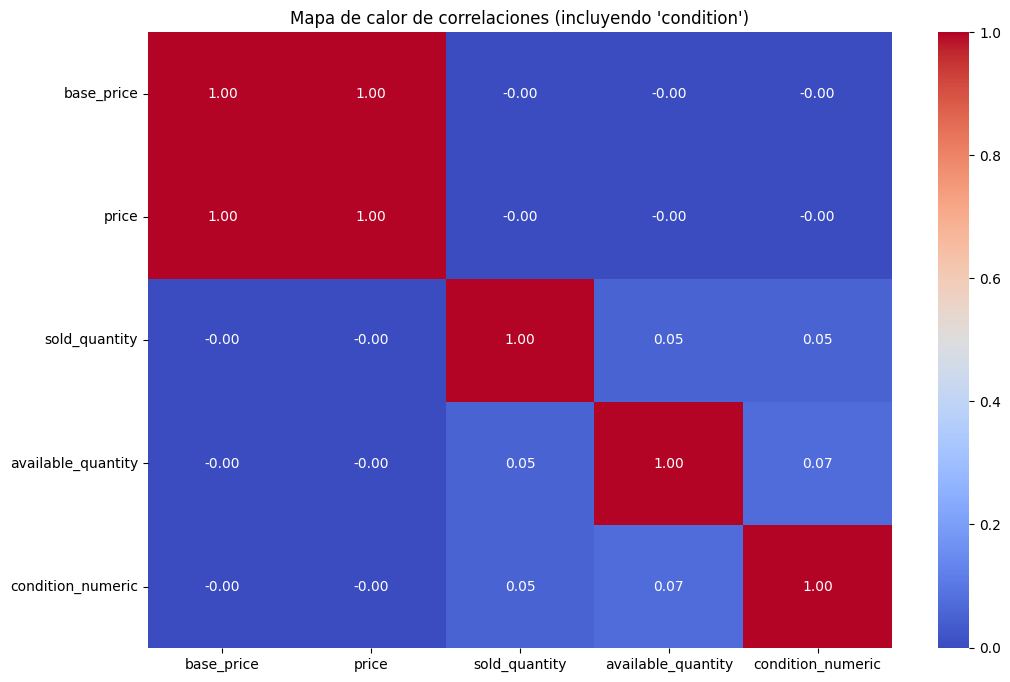

In [74]:
# Si 'condition' tiene valores como "nuevo" y "usado", podemos mapearlos a 1 y 0, respectivamente:
mapping = {'new': 1, 'used': 0}  # Ajusta el mapeo según los datos
df_exploit_clean_reorder['condition_numeric'] = df_exploit_clean_reorder['condition'].map(mapping)

# Seleccionar las columnas numéricas, incluyendo la columna convertida
df_numeric = df_exploit_clean_reorder.select_dtypes(include=['number'])

# Calcular la matriz de correlación
corr_matrix = df_numeric.corr()

# Graficar el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de calor de correlaciones (incluyendo 'condition')")
plt.show()

# Vamos a comparar las columnas numéricas entre si
de esta manera identificamos las columnas que estén correlacionadas

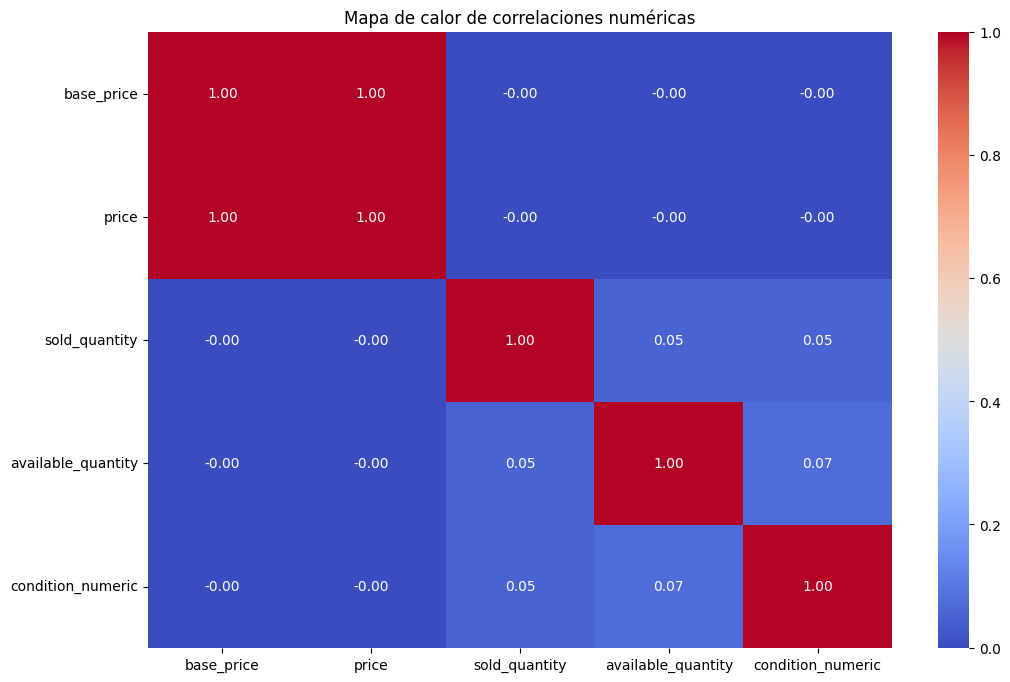

In [75]:
# Seleccionar columnas numéricas (por ejemplo, si df_exploit_clean_reorder es tu DataFrame)
df_numeric = df_exploit_clean_reorder.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
corr_matrix = df_numeric.corr()

# Graficar el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de calor de correlaciones numéricas")
plt.show()

# Exportar dataset limpio para la difusion

In [76]:
ruta_exportar = 'dataset_clean'


# Exporta a Excel (usa la librería openpyxl)
df_exploit_clean.to_excel(ruta_exportar + '.xlsx', index=False) # index=False evita que se exporte el índice
df_exploit_clean.to_csv(ruta_exportar + '.csv', index=False) # index=False evita que se exporte el índice